In [1]:
import os
import time
import pickle
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
import torch
import torch.optim as optim

from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold, StratifiedKFold
from category_encoders import TargetEncoder, OneHotEncoder
from math import sqrt
from datetime import datetime

In [2]:
from src.utils import check_stationarity, get_scaler, get_sample_weight, load_word2vec_embeddings, get_torch_optimizer, dummy_lagged_df
from src.arima import grid_search_arima
from src.sarimax import grid_search_sarimax
from src.ml_model import grid_search_ml, get_model, one_step_prediction as one_step_ml_prediction
from src.rnn import load_data, load_data_forecast, train_rnn, eval_rnn, one_step_prediction, grid_search_rnn, TimeSeriesDataset, ForecastModel

# Imputing Visitor Arrivals for Missing Data
For example, Chile has missing data from 2017M11-M12, Maldives has missing data from 2013M3-M12
## Baseline of simple SARIMA 
A simple SARIMA should be suffice since there should be no shocks between these periods

In [3]:
imputed_dir = './data/imputed/'

In [4]:
aus_df = pd.read_csv(os.path.join(imputed_dir, 'Chile.csv'))
aus_df['Date'] = pd.to_datetime(aus_df['Date'])
aus_df = aus_df[aus_df['Date'] < '2020-01-01']
aus_df = aus_df.set_index('Date')

In [5]:
candidates = ['GDPPerCap', 'GDP', 'Population', 'FSI', 'FXAgainstChina', 'Temperature', 'Precipitation']
target = 'VisitorArrivals'

train_df = aus_df[[target] + candidates]
train_df = train_df.loc[train_df[target].first_valid_index(): train_df[target].last_valid_index()]
train_x, train_y = train_df[candidates], train_df[target]
# train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2)
train_x, test_x, train_y, test_y = train_x.iloc[:-1*12], train_x.iloc[-1*12:], train_y.iloc[:-1*12], train_y.iloc[-1*12:]
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

In [6]:
len(test_y) / (len(train_y) + len(test_y))

0.125

/scratch/zt00296/Projects/tourism-forecasting/src/utils.py:46: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)



The series isn't stationary


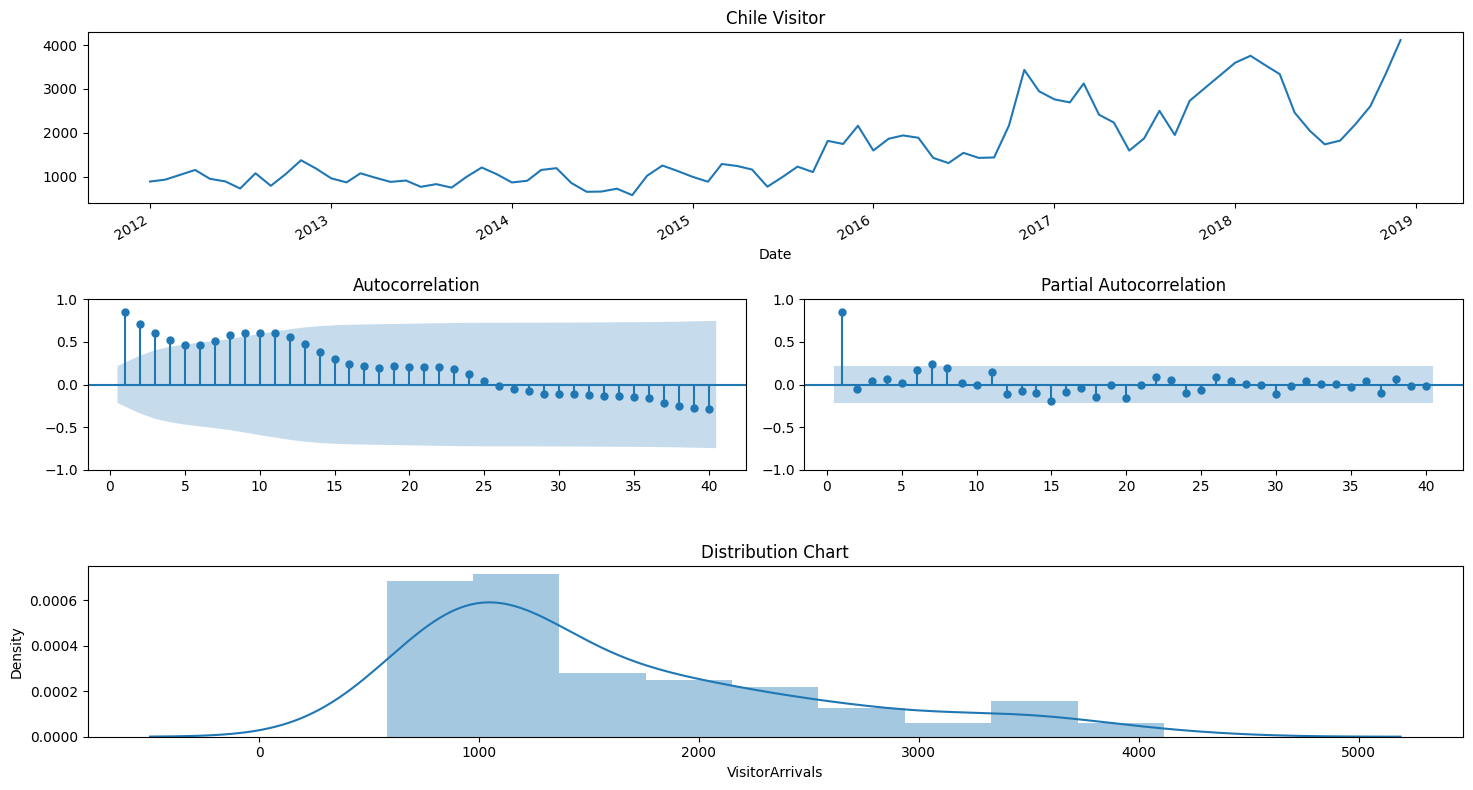

In [7]:
# find parameter analytically
check_stationarity(train_y.dropna(), title='Chile Visitor')

/scratch/zt00296/Projects/tourism-forecasting/src/utils.py:46: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)



The series isn't stationary


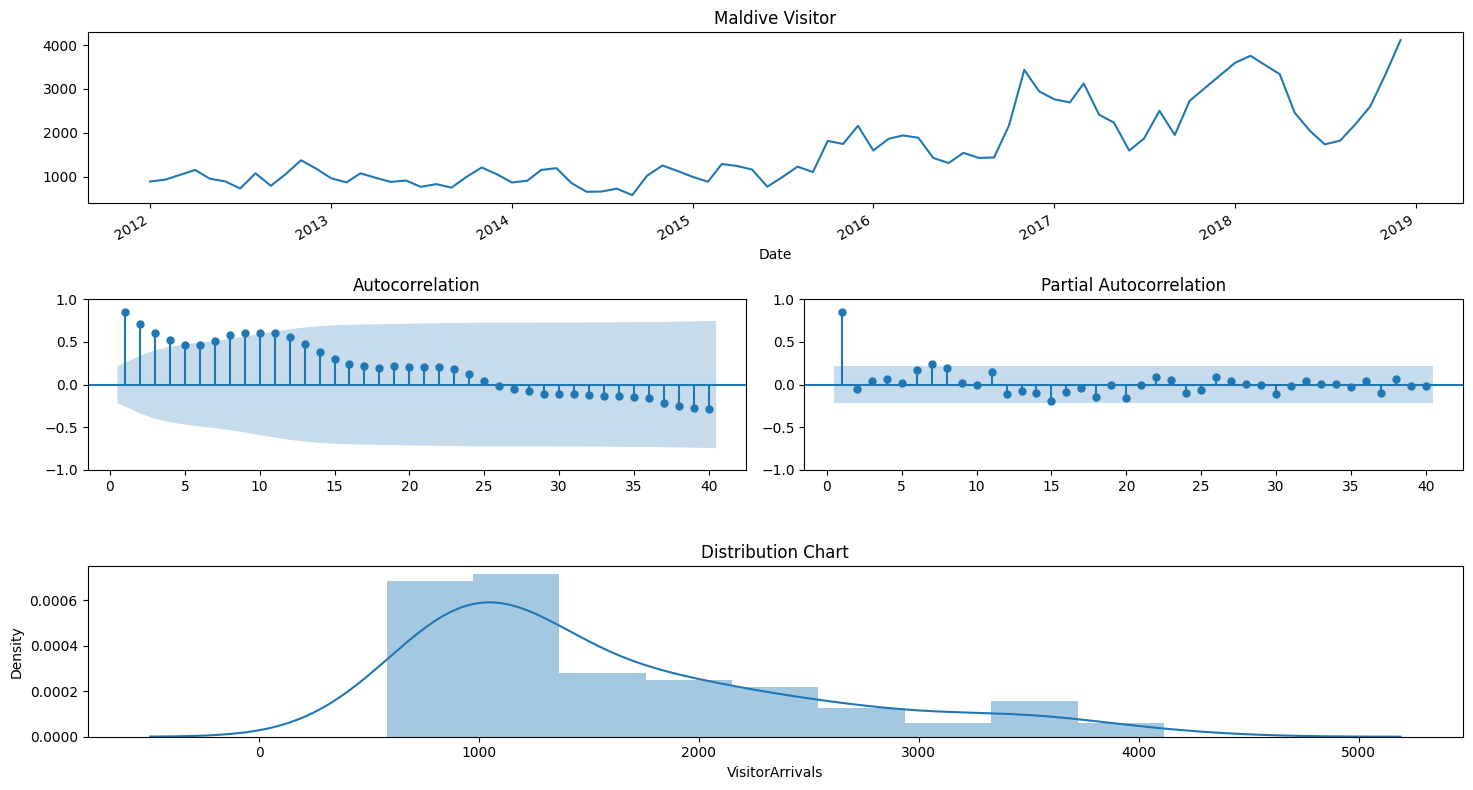

In [8]:
# find parameter analytically
check_stationarity(train_y.dropna(), title='Maldive Visitor')

/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty sl

[(3, 0, 1), (1, 1, 1, 12), 'c'] 217.35956147674


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RMSE: 458.50836058837103
R2 0.3960283934265201


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='Date'>

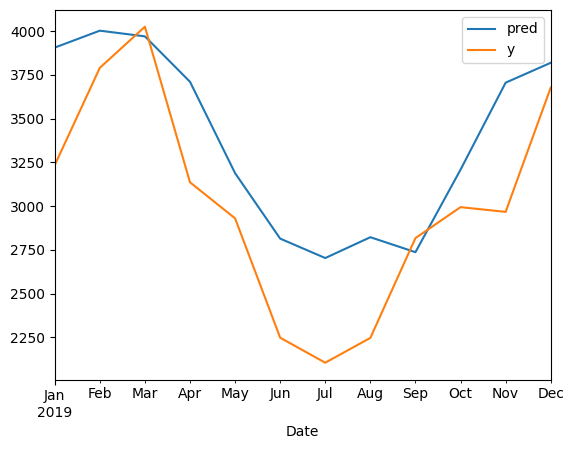

In [9]:
best_param, best_rmse, best_r2 = grid_search_sarimax(train_y, test_y, cv=True)
print(best_param, best_rmse)
sarima_model = sm.tsa.statespace.SARIMAX(train_y, order=best_param[0], seasonal_order=best_param[1], trend=best_param[2])
result = sarima_model.fit(disp=False)
pred = result.forecast(len(test_y))
print('RMSE:', sqrt(mean_squared_error(test_y, pred)))
print('R2', r2_score(test_y, pred))
pd.concat([pd.Series(pred, name='pred', index=test_y.index), pd.Series(test_y, name='y')], axis=1).plot()

In [9]:
# repeat for chile and maldives
sarima_pred, all_y = [], []
for f in ['Chile.csv', 'Maldives.csv']:
    print('processing', f)
    df = pd.read_csv(os.path.join(imputed_dir, f))
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[df['Date'] < '2020-01-01']
    df = df.set_index('Date')
    train_y = df[target]
    train_y = train_y.loc[train_y.first_valid_index(): train_y.last_valid_index()]
    train_y, test_y = train_y.iloc[:-1*12], train_y.iloc[-1*12:]
    best_param, best_rmse, best_r2 = grid_search_sarimax(train_y, test_y, cv=True)
    print(best_param, best_rmse, best_r2)
    sarima_model = sm.tsa.statespace.SARIMAX(train_y, order=best_param[0], seasonal_order=best_param[1], trend=best_param[2])
    result = sarima_model.fit(disp=False)
    pred = result.forecast(len(test_y))
    sarima_pred.append(pred)
    all_y.append(test_y)
sarima_pred, all_y = pd.concat(sarima_pred).values, pd.concat(all_y).values

processing Chile.csv


/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty sl

[(3, 0, 0), (1, 0, 0, 12), 'c'] 276.49106960737214 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


processing Maldives.csv


/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty sl

[(2, 0, 1), (1, 1, 1, 12), 'n'] 2175.1473586098073 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


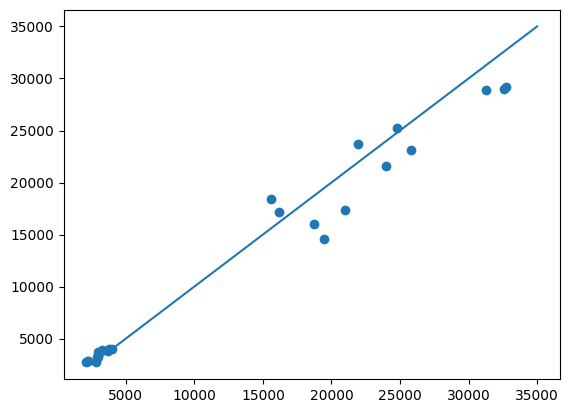

In [11]:
plt.scatter(all_y, sarima_pred)
plt.plot((4000, 35000), (4000, 35000))

In [12]:
baseline_rmse = sqrt(mean_squared_error(all_y, sarima_pred))
baseline_r2 = r2_score(all_y, sarima_pred)
print(f'Baseline SARIMA RMSE: {baseline_rmse:.5f}\nBaseline SARIMA R2: {baseline_r2:.5f}')

Baseline SARIMA RMSE: 2090.07368
Baseline SARIMA R2: 0.96462


# SARIMAX

In [13]:
candidates = ['GDPPerCap', 'GDP', 'Population', 'FSI', 'FXAgainstChina', 'Temperature', 'Precipitation']
target = 'VisitorArrivals'

train_df = aus_df[[target] + candidates]
train_df = train_df.loc[train_df[target].first_valid_index(): train_df[target].last_valid_index()]
train_x, train_y = train_df[candidates], train_df[target]
# train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2)
train_x, test_x, train_y, test_y = train_x.iloc[:-1*12], train_x.iloc[-1*12:], train_y.iloc[:-1*12], train_y.iloc[-1*12:]
# scaler = StandardScaler()
# train_x = scaler.fit_transform(train_x)
# test_x = scaler.transform(test_x)

In [14]:
train_x

,GDPPerCap,GDP,Population,FSI,FXAgainstChina,Temperature,Precipitation
Date,,,,,,,
2012-01-01,23300.000000,4.054361e+11,17400359.0,43.500000,79.316767,14.3,71.3
2012-02-01,23358.916667,4.068027e+11,17414622.0,43.500000,76.362966,12.7,89.5
2012-03-01,23417.833333,4.081694e+11,17428884.0,43.500000,76.936030,12.3,100.5
2012-04-01,23476.750000,4.095360e+11,17443147.0,43.500000,77.076469,9.4,58.6
2012-05-01,23535.666667,4.109027e+11,17457410.0,43.500000,78.869259,7.6,115.8
...,...,...,...,...,...,...,...
2018-08-01,24993.416667,4.713465e+11,18859173.0,40.691036,96.187380,6.0,78.4
2018-09-01,24988.333333,4.717145e+11,18877745.0,40.691036,99.269181,7.9,98.9
2018-10-01,24983.250000,4.720825e+11,18896318.0,40.691036,98.000754,8.6,69.5


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE: 619.9136168554371
R2 -0.10403885044504402


<Axes: xlabel='Date'>

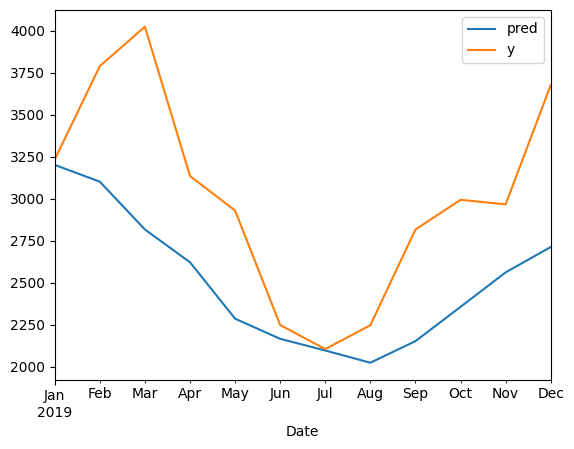

In [15]:
best_param = [(2, 0, 0), (1, 0, 1, 12), 'n']
sarimax_model = sm.tsa.statespace.SARIMAX(train_y, train_x, order=best_param[0], seasonal_order=best_param[1], trend=best_param[2])
result = sarimax_model.fit(disp=False)
pred = result.forecast(len(test_y), exog=test_x)
print('RMSE:', sqrt(mean_squared_error(test_y, pred)))
print('R2', r2_score(test_y, pred))
pd.concat([pd.Series(pred, name='pred', index=test_y.index), pd.Series(test_y, name='y')], axis=1).plot()

In [16]:
# repeat for chile and maldives
sarimax_pred, all_y = [], []
for f in ['Chile.csv', 'Maldives.csv']:
    print('processing', f)
    df = pd.read_csv(os.path.join(imputed_dir, f))
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[df['Date'] < '2020-01-01']
    df = df.set_index('Date')
    train_df = df[[target] + candidates]
    train_df = train_df.loc[train_df[target].first_valid_index(): train_df[target].last_valid_index()]
    train_x, train_y = train_df[candidates], train_df[target]
    train_x, test_x, train_y, test_y = train_x.iloc[:-1*12], train_x.iloc[-1*12:], train_y.iloc[:-1*12], train_y.iloc[-1*12:]
    best_param, best_rmse, best_r2 = grid_search_sarimax(train_y, test_y, train_x, test_x)
    print(best_param, best_rmse, best_r2)
    if best_param is not None:
        sarimax_model = sm.tsa.statespace.SARIMAX(train_y, train_x, order=best_param[0], seasonal_order=best_param[1], trend=best_param[2])
        result = sarimax_model.fit(disp=False)
        pred = result.forecast(len(test_y), exog=test_x)
    else:
        pred = pd.Series(np.resize(train_y[-12:].values, len(test_y)), name='predictions')
    sarimax_pred.append(pred)
    all_y.append(test_y)
sarimax_pred, all_y = pd.concat(sarimax_pred).values, pd.concat(all_y).values

processing Chile.csv
None 391.268130570329 None
processing Maldives.csv
None 3032.145321385504 None


In [17]:
train_x

,GDPPerCap,GDP,Population,FSI,FXAgainstChina,Temperature,Precipitation
Date,,,,,,,
1998-01-01,12609.000000,3.384931e+09,268445.0,77.734438,1.443896,28.4,209.3
1998-02-01,12653.250000,3.402351e+09,268868.0,77.734438,1.443866,28.9,44.0
1998-03-01,12697.500000,3.419771e+09,269291.0,77.734438,1.449332,29.2,42.2
1998-04-01,12741.750000,3.437191e+09,269714.0,77.734438,1.441005,29.6,95.7
1998-05-01,12786.000000,3.454612e+09,270137.0,77.734438,1.417720,29.2,232.4
...,...,...,...,...,...,...,...
2018-08-01,19211.666667,1.008124e+10,524602.0,72.400000,2.251708,27.8,174.4
2018-09-01,19271.333333,1.013684e+10,525873.0,72.400000,2.250828,28.1,186.3
2018-10-01,19331.000000,1.019244e+10,527144.0,72.400000,2.229661,27.9,227.2


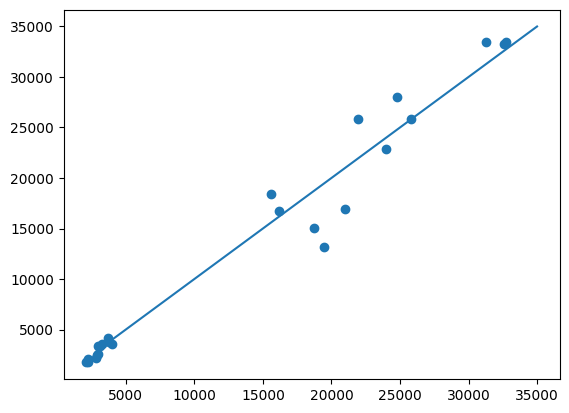

In [18]:
plt.scatter(all_y, sarimax_pred)
plt.plot((4000, 35000), (4000, 35000))

In [19]:
sarimax_rmse = sqrt(mean_squared_error(all_y, sarimax_pred))
sarimax_r2 = r2_score(all_y, sarimax_pred)
print(f'Baseline SARIMAX RMSE: {sarimax_rmse:.5f}\nBaseline SARIMAX R2: {sarimax_r2:.5f}')

Baseline SARIMAX RMSE: 2161.82747
Baseline SARIMAX R2: 0.96215


## Regression

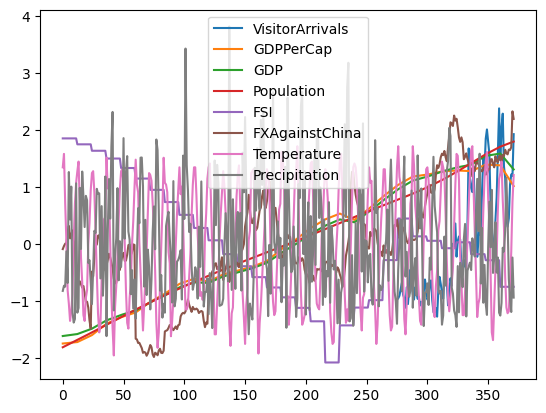

Pearson: 0.44561987624278304
Kendall: 0.42667546458264105
Spearman: 0.5779765800954983


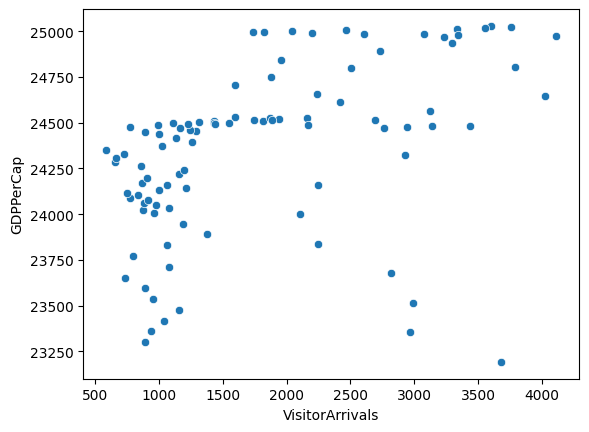

Pearson: 0.7765221391043217
Kendall: 0.6034880221423371
Spearman: 0.8240995398507726


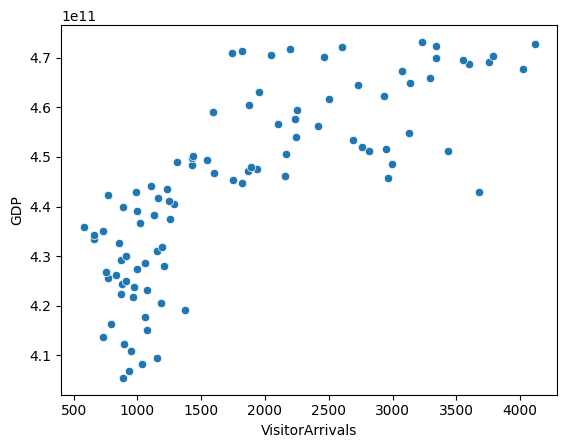

Pearson: 0.8400779659363687
Kendall: 0.6258638048608097
Spearman: 0.8460544566477254


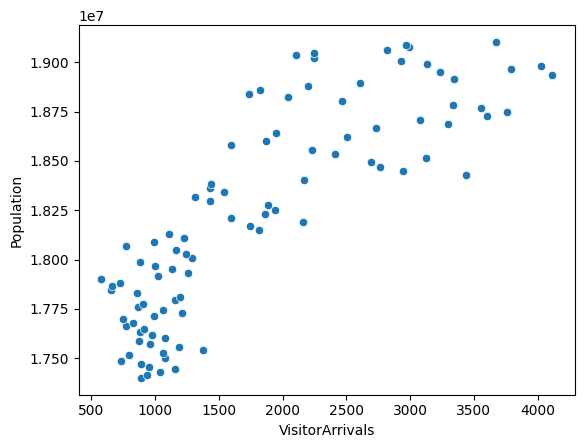

Pearson: -0.7194264316303574
Kendall: -0.6070263118882002
Spearman: -0.7985506124338352


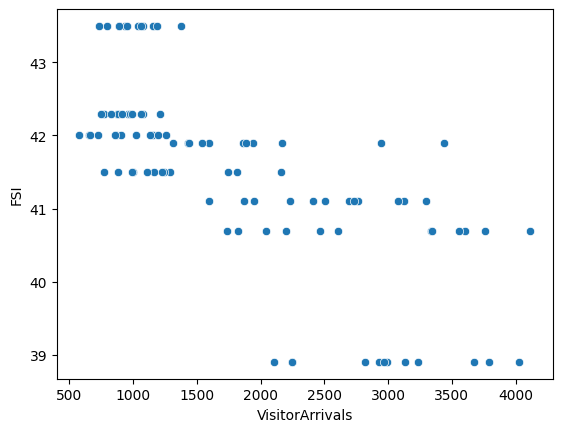

Pearson: 0.4633230125427411
Kendall: 0.2735549122542691
Spearman: 0.46831729842323006


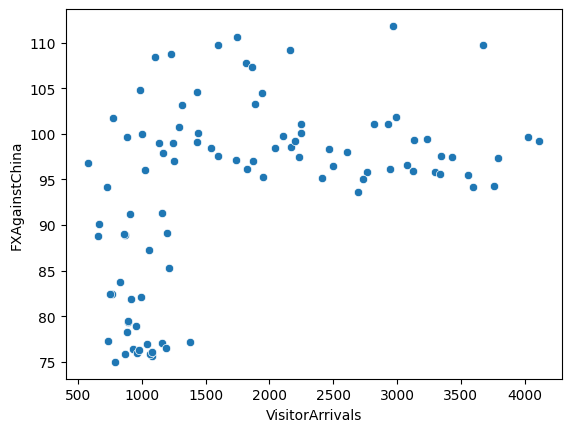

Pearson: 0.3130021240276724
Kendall: 0.1903517941863472
Spearman: 0.27757502859382693


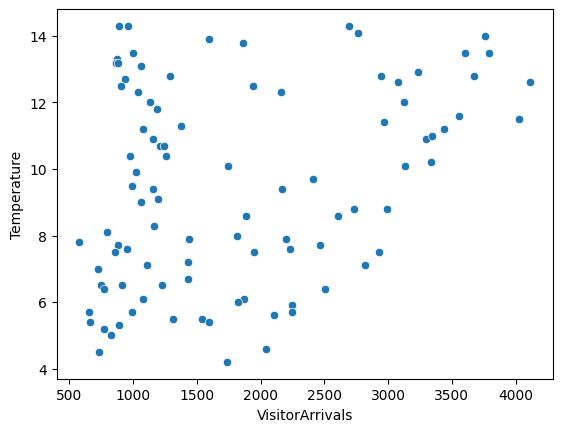

Pearson: -0.20637560195670487
Kendall: -0.1110867286006002
Spearman: -0.17634889953126615


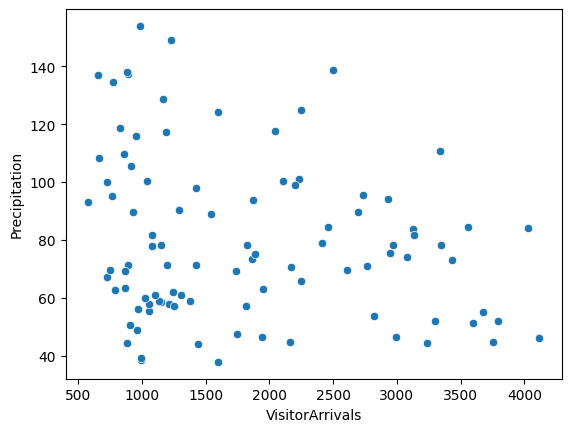

In [39]:
candidates = ['GDPPerCap', 'GDP', 'Population', 'FSI', 'FXAgainstChina', 'Temperature', 'Precipitation']
target = 'VisitorArrivals'
aus_df['Year'] = aus_df.index.year
pd.DataFrame(StandardScaler().fit_transform(aus_df[[target] + candidates]), columns=[target] + candidates).plot()
plt.show()
for candidate in candidates:
    print('Pearson:', aus_df[target].corr(aus_df[candidate]))
    print('Kendall:', aus_df[target].corr(aus_df[candidate], method='kendall'))
    print('Spearman:', aus_df[target].corr(aus_df[candidate], method='spearman'))
    sns.scatterplot(aus_df, x=target, y=candidate)
    plt.show()

In [21]:
train_df = aus_df[[target] + candidates].dropna()
train_x, train_y = train_df[candidates], train_df[target]

train_y, train_x, _ = dummy_lagged_df(train_y, train_x, lag=1)

# train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2)
train_x, test_x, train_y, test_y = train_x.iloc[:-1*12], train_x.iloc[-1*12:], train_y.iloc[:-1*12], train_y.iloc[-1*12:]

In [ ]:
# sample_weight = get_sample_weight(0.5, 1.0, len(train_x))
best_param, best_rmse = grid_search_ml(train_x, train_y, #sample_weight=sample_weight,
                                         additional_params={'rf': [{'n_estimators': n} for n in (3, 5, 10, 50, 100)],
                                                            'mlp': [{'hidden_layer_sizes': n} for n in (1, 2, 3, 5, 10)],
                                                            'xgb': [{'n_estimators': n} for n in (3, 5, 10, 50, 100)]})
best_param, best_rmse

RMSE: 7208.93350
R2: -0.56083


<Axes: xlabel='Date'>

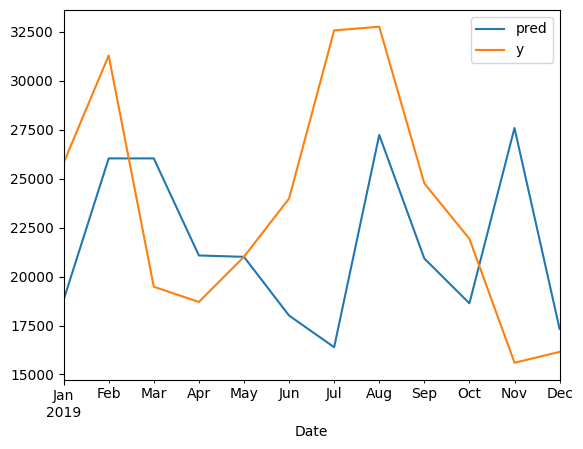

In [35]:
model = get_model(best_param[0])
model = model.set_params(**best_param[2])
scaler = get_scaler(best_param[1])
train_x_ = scaler.fit_transform(train_x)
test_x_ = scaler.transform(test_x)
model.fit(train_x_, train_y, )#sample_weight=sample_weight)
pred = model.predict(test_x_)
linear_r2 = r2_score(test_y, pred)
linear_rmse = sqrt(mean_squared_error(test_y, pred))
print(f'RMSE: {linear_rmse:.5f}\nR2: {linear_r2:.5f}')

pd.concat([pd.Series(pred, name='pred', index=test_y.index), pd.Series(test_y, name='y')], axis=1).plot()

In [40]:
# repeat for all countries
reg_pred, all_y = [], []
for f in ['Chile.csv', 'Maldives.csv']:
    if f.endswith('.csv'):
        print('processing', f)
        df = pd.read_csv(os.path.join(imputed_dir, f))
        df['Date'] = pd.to_datetime(df['Date'])
        df = df[df['Date'] < '2020-01-01']
        df = df.set_index('Date')

        train_df = df[[target] + candidates].dropna()
        train_x, train_y = train_df[candidates], train_df[target]
        
        train_y, train_x, _ = dummy_lagged_df(train_y, train_x, lag=1)
        
        train_x, test_x, train_y, test_y = train_x.iloc[:-1*12], train_x.iloc[-1*12:], train_y.iloc[:-1*12], train_y.iloc[-1*12:]
        # sample_weight = get_sample_weight(0.5, 1.0, len(train_x))

        best_param, best_rmse = grid_search_ml(train_x, train_y, #sample_weight=sample_weight,
                                                 additional_params={'rf': [{'n_estimators': n} for n in (3, 5, 10, 50, 100)],
                                                                    'mlp': [{'hidden_layer_sizes': n} for n in (1, 2, 3, 5, 10)],
                                                                    'xgb': [{'n_estimators': n} for n in (3, 5, 10, 50, 100)]})
        print(best_param, best_rmse)
        model = get_model(best_param[0])
        model = model.set_params(**best_param[2])
        scaler = get_scaler(best_param[1])
        train_x_ = scaler.fit_transform(train_x)
        test_x_ = scaler.transform(test_x)
        model.fit(train_x_, train_y,)# sample_weight=sample_weight)
        pred = model.predict(test_x_)
        reg_pred.append(pred)
        all_y.append(test_y)
reg_pred, all_y = np.concatenate(reg_pred), pd.concat(all_y).values

processing Chile.csv
('ridge', 'standard', {'alpha_per_target': False, 'alphas': (0.1, 0.25, 0.5, 1.0, 5.0, 10.0), 'cv': None, 'fit_intercept': True, 'gcv_mode': None, 'scoring': None, 'store_cv_values': False}) 324.7279232058987
processing Maldives.csv
('rf', 'minmax', {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}) 3787.311433244116


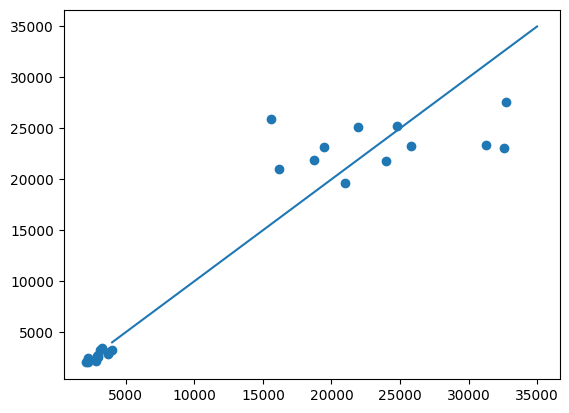

In [41]:
plt.scatter(all_y, reg_pred)
plt.plot((4000, 35000), (4000, 35000))

In [42]:
reg_rmse = sqrt(mean_squared_error(all_y, reg_pred))
reg_r2 = r2_score(all_y, reg_pred)
print(f'Baseline Model RMSE: {reg_rmse:.5f}\nBaseline Model R2: {reg_r2:.5f}')

Baseline Model RMSE: 3877.91554
Baseline Model R2: 0.87821


# RNN

In [43]:
candidates = ['GDPPerCap', 'GDP', 'Population', 'FSI', 'FXAgainstChina', 'Country', 'Temperature', 'Precipitation']
target = 'VisitorArrivals'
seq_len = 7

seq_train_x, seq_train_y, seq_test_x, seq_test_y, x_scaler, y_scaler, train_country = load_data(imputed_dir, candidates, target, seq_len, reverse=False, freq='MS', remove_covid=True, test_size=1*12,
                                                                                                preprocess='minmax', single_x_scaler=False, single_y_scaler=True)
# seq_test_x = pd.concat(seq_test_x, ignore_index=True)

In [44]:
seq_test_x[-1]

,GDPPerCap,GDP,Population,FSI,FXAgainstChina,Country,Temperature,Precipitation,ShiftedTarget
192,0.835330,0.902742,1.029472,-0.296296,0.675663,Austria,0.585938,0.956565,0.017708
193,0.792628,0.876731,1.035094,-0.296296,0.641738,Austria,0.933594,0.368947,0.019813
194,0.749925,0.850719,1.040716,-0.296296,0.663760,Austria,0.945312,0.637044,0.023154
195,0.707223,0.824707,1.046338,-0.296296,0.624211,Austria,0.937500,0.564653,0.022108
196,0.664521,0.798695,1.051960,-0.296296,0.631097,Austria,0.746094,0.576635,0.018301
197,0.621819,0.772683,1.057582,-0.296296,0.627679,Austria,0.609375,0.377434,0.020953
198,0.579117,0.746672,1.063203,-0.296296,0.651940,Austria,0.394531,0.548677,0.012360


In [45]:
seq_train_x, seq_val_x, seq_train_y, seq_val_y = train_test_split(seq_train_x, seq_train_y, test_size=0.2, stratify=train_country)
train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y,)# (model.num_layers, model.hidden_size))
# train_dataset.initialize_states()
val_dataset = TimeSeriesDataset(seq_val_x, seq_val_y,)# (model.num_layers, model.hidden_size))
# val_dataset.set_initial_states(train_dataset.get_initial_states())
test_dataset = TimeSeriesDataset(seq_test_x, seq_test_y,)# (model.num_layers, model.hidden_size))
# test_dataset.set_initial_states(train_dataset.get_initial_states())

In [46]:
model = ForecastModel('gru', input_size=8, num_layers=2, conditional_labels=np.unique(train_country).tolist())
optimizer = get_torch_optimizer('sgd', model.parameters(), lr=0.001)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [47]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8, pin_memory=True)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=1, pin_memory=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

Epoch 0: train loss 0.0253, val loss 0.0144, time 3.7753
Epoch 1: train loss 0.0171, val loss 0.0127, time 3.1796
Epoch 2: train loss 0.0155, val loss 0.0119, time 3.1161
Epoch 3: train loss 0.0141, val loss 0.0114, time 3.2319
Epoch 4: train loss 0.0138, val loss 0.0109, time 3.1257
Epoch 5: train loss 0.0137, val loss 0.0107, time 3.0348
Epoch 6: train loss 0.0134, val loss 0.0105, time 3.0946
Epoch 7: train loss 0.0124, val loss 0.0100, time 3.1021
Epoch 8: train loss 0.0125, val loss 0.0097, time 3.1430
Epoch 9: train loss 0.0121, val loss 0.0094, time 3.1105
Epoch 10: train loss 0.0116, val loss 0.0090, time 3.1419
Epoch 11: train loss 0.0114, val loss 0.0087, time 3.1200
Epoch 12: train loss 0.0114, val loss 0.0083, time 3.1626
Epoch 13: train loss 0.0106, val loss 0.0081, time 3.1679
Epoch 14: train loss 0.0095, val loss 0.0074, time 3.1940
Epoch 15: train loss 0.0095, val loss 0.0070, time 3.2083
Epoch 16: train loss 0.0089, val loss 0.0065, time 3.1991
Epoch 17: train loss 0.0

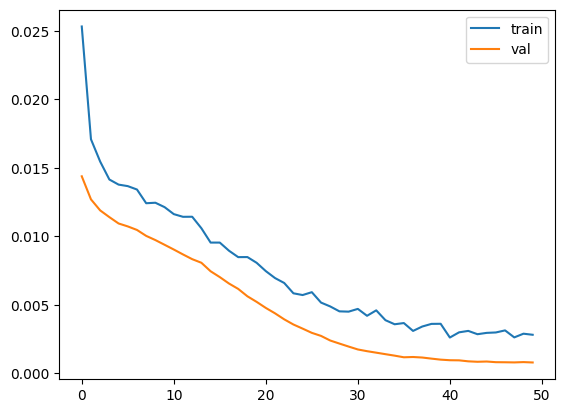

In [48]:
model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, val_dataloader, cuda=True)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend();

In [49]:
len(train_dataset) + len(val_dataset)

4105

In [50]:
# best_param, best_rmse = grid_search_rnn(imputed_dir, candidates, target, input_size=8, param_grids={'seq_len': [10, 25, 50], 'hidden_size': [10, 20, 50], 'num_layers': range(1, 3)},
#                                         freq='MS', remove_covid=True, test_size=1*12, max_epochs=10)
# best_param, best_rmse

Epoch 0: train loss 0.3073, val loss 0.2464, time 3.2618
Epoch 1: train loss 0.0659, val loss 0.1651, time 3.0466
Epoch 2: train loss 0.0566, val loss 0.1871, time 3.0392
Epoch 3: train loss 0.0449, val loss 0.1474, time 3.0542
Epoch 4: train loss 0.0521, val loss 0.1730, time 2.9878
Epoch 5: train loss 0.0452, val loss 0.1322, time 3.0206
Epoch 6: train loss 0.0425, val loss 0.1571, time 3.0303
Epoch 7: train loss 0.0556, val loss 0.1308, time 3.0169
Epoch 8: train loss 0.0439, val loss 0.1790, time 3.0114
Epoch 9: train loss 0.0489, val loss 0.1321, time 2.9821
warning not converged


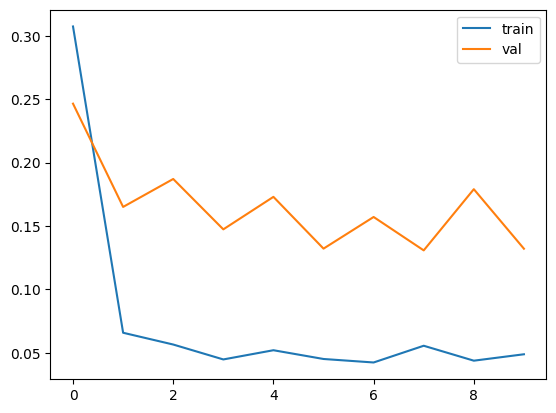

In [51]:
best_param = ({'preprocess': 'standard', 'seq_len': 20, 'batch_size': 64}, 
              {'model_type': 'lstm', 'num_layers': 1, 'hidden_size': 20}, 
              {'optim_type': 'rmsprop', 'lr': 0.0001})

seq_train_x, seq_train_y, seq_test_x, seq_test_y, x_scaler, y_scaler, train_country = load_data(imputed_dir, candidates, target, best_param[0]['seq_len'], freq='MS', remove_covid=True, test_size=1*12,
                                                                                                reverse=False, preprocess=best_param[0]['preprocess'], single_y_scaler=True)
model = ForecastModel(**best_param[1], input_size=8, conditional_labels=np.unique(train_country).tolist())
optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
criterion = nn.MSELoss()

train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y,)# (model.num_layers, model.hidden_size))
test_dataset = TimeSeriesDataset(seq_test_x, seq_test_y,)# (model.num_layers, model.hidden_size))
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8, pin_memory=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, cuda=True, epochs=10)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend();

In [52]:
rnn_preds, _ = eval_rnn(model, criterion, test_dataloader)
rnn_preds = y_scaler.inverse_transform(np.expand_dims(rnn_preds, -1)).flatten()

In [53]:
idx = []
for i in range(len(test_dataset)):
    cond_label, _, _ = test_dataset.__getitem__(i)
    if cond_label in ['Chile', 'Maldives']:
        idx.append(i)
assert len(idx) == len(all_y)
rnn_preds = rnn_preds[idx]

In [54]:
dataloader_gt = []
for _, _, y_batch in test_dataloader:
    dataloader_gt.append(y_batch.item())
dataloader_gt = y_scaler.inverse_transform(np.expand_dims(np.asarray(dataloader_gt), -1)).flatten()

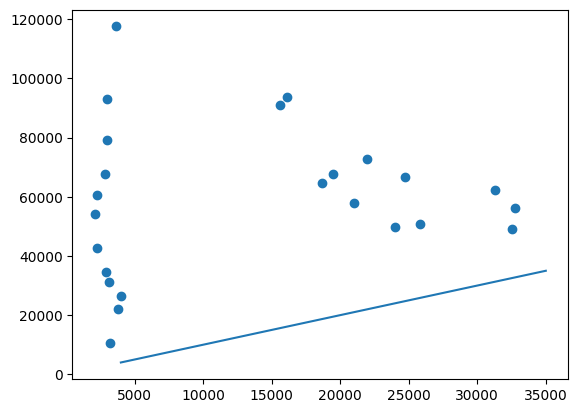

In [55]:
plt.scatter(all_y, rnn_preds)
plt.plot((4000, 35000), (4000, 35000))

In [56]:
rnn_rmse = sqrt(mean_squared_error(all_y, rnn_preds))
rnn_r2 = r2_score(all_y, rnn_preds)
print(f'RNN RMSE: {rnn_rmse:.5f}\nRNN R2: {rnn_r2:.5f}')

RNN RMSE: 52648.10470
RNN R2: -21.44786


# Separate RNN models

In [58]:
rnn_sep_pred = []
for f in os.listdir(imputed_dir):
    if f.endswith('.csv'):
        country = f.split('.')[0]
        if country not in ['Chile', 'Maldives']:
            continue
        print('processing', f)
        best_param, best_rmse = grid_search_rnn(imputed_dir, candidates, target, emb_dict=None, freq='MS', test_size=1*12, input_size=8, max_epochs=10,
                                                param_grids={'seq_len': [10, 20, 50], 'hidden_size': [10, 20, 30], 'num_layers': range(1, 2), 
                                                             'batch_size': [64, 128], 'lr': [0.0001, 0.00005, 0.00001]},
                                                country_filter=country, verbose=False)
        print(best_param, best_rmse)

        seq_train_x, seq_train_y, seq_test_x, seq_test_y, x_scaler, y_scaler, train_country = load_data(imputed_dir, candidates, target, best_param[0]['seq_len'], freq='MS', test_size=1*12, reverse=False, country_filter=country, preprocess=best_param[0]['preprocess'], single_y_scaler=True)
        model = ForecastModel(**best_param[1], input_size=8, conditional_labels=np.unique(train_country).tolist())
        optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
        criterion = nn.MSELoss()

        train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y,)# (model.num_layers, model.hidden_size))
        # train_dataset.initialize_states()
        test_dataset = TimeSeriesDataset(seq_test_x, seq_test_y,)# (model.num_layers, model.hidden_size))
        # test_dataset.set_initial_states(train_dataset.get_initial_states())
        train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8, pin_memory=True)
        test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

        model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, epochs=10, cuda=True, verbose=False)
        preds, _ = eval_rnn(model, criterion, test_dataloader)
        preds = y_scaler.inverse_transform(np.expand_dims(preds, -1)).flatten()
        rnn_sep_pred.append(preds)
rnn_sep_pred = np.concatenate(rnn_sep_pred)

processing Chile.csv
({'preprocess': 'standard', 'seq_len': 50, 'batch_size': 64}, {'model_type': 'lstm', 'num_layers': 1, 'hidden_size': 30}, {'optim_type': 'rmsprop', 'lr': 0.0005}) 0.2136043966021323
processing Maldives.csv
({'preprocess': 'standard', 'seq_len': 20, 'batch_size': 64}, {'model_type': 'gru', 'num_layers': 1, 'hidden_size': 30}, {'optim_type': 'rmsprop', 'lr': 0.001}) 0.27511221630445737


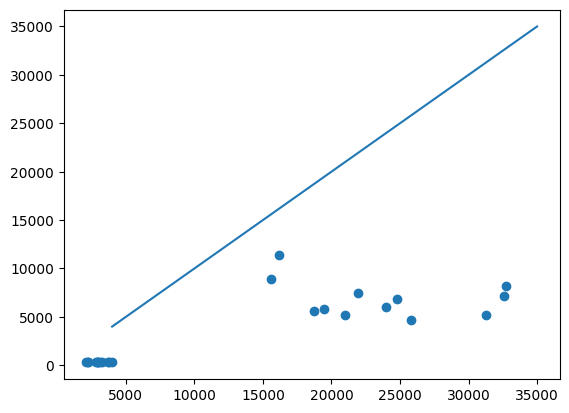

In [59]:
plt.scatter(all_y, rnn_sep_pred)
plt.plot((4000, 35000), (4000, 35000))

In [60]:
rnn_sep_rmse = sqrt(mean_squared_error(all_y, rnn_sep_pred))
rnn_sep_r2 = r2_score(all_y, rnn_sep_pred)
print(f'Separate RNN RMSE: {rnn_sep_rmse:.5f}\n Separate RNN R2: {rnn_sep_r2:.5f}')

Separate RNN RMSE: 12895.09500
 Separate RNN R2: -0.34666


# Full Run
Best model seems to be SARIMA

processing Chile.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


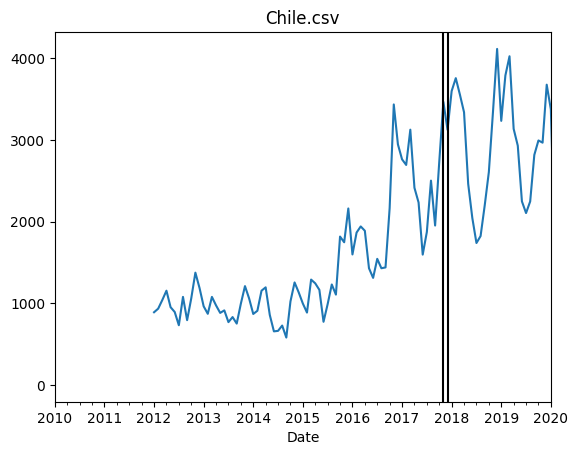

/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Maldives.csv


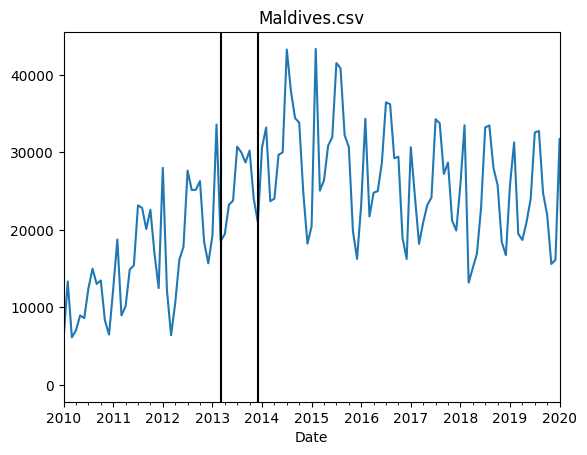

In [11]:
# fill missing values with sarima

for f in ['Chile.csv', 'Maldives.csv']:
    print('processing', f)
    full_df = pd.read_csv(os.path.join(imputed_dir, f))
    full_df['Date'] = pd.to_datetime(full_df['Date'])
    full_df = full_df.set_index('Date')
    df = full_df.copy()
    df = df[df.index < '2020-01-01']

    # forward
    train_full = df[target]
    train_y = train_full.loc[train_full.first_valid_index(): train_full.last_valid_index()]
    train_y, test_y = train_y.iloc[:-1*12], train_y.iloc[-1*12:]
    
    if f == 'Chile.csv':
        best_param = [(3, 0, 0), (1, 0, 0, 12), 'c']
    elif f == 'Maldives.csv':
        best_param = [(2, 0, 1), (1, 1, 1, 12), 'n']
    else:
        best_param, best_rmse, best_r2 = grid_search_sarimax(train_y, test_y)
        print(best_param, best_rmse, best_r2)
    train_y = train_full.loc[train_full.first_valid_index(): train_full.last_valid_index()]
    test_y = train_y[train_y.isna()]
    sarima_model = sm.tsa.statespace.SARIMAX(train_y, order=best_param[0], seasonal_order=best_param[1], trend=best_param[2])
    result = sarima_model.fit(disp=False)
    pred = result.predict(test_y.index.min(), test_y.index.max())
    pred_df = pd.DataFrame({'VisitorImputed': pred}, index=test_y.index).astype(int)

    full_df[target] = full_df[target].fillna(full_df.merge(pred_df, how='left', left_index=True, right_index=True)['VisitorImputed'])
    full_df.reset_index(names='Date')
    full_df[target].plot()
    plt.title(f)
    plt.axvline(test_y.index.min(), color='black')
    plt.axvline(test_y.index.max(), color='black')
    plt.xlim(datetime(2010, 1, 1), datetime(2020, 1, 1))
    plt.show()
    full_df.to_csv(os.path.join(imputed_dir, f))
    # break